In [2]:
from scipy import integrate
import pandas as pd
import numpy as np
import noisegen
from scipy.constants import physical_constants
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.integrate
import matplotlib

In [3]:
# Define a function to calculate the qubit gap as a function of the flux noise.
def delta_gap_func(delta_flux, D=1):
    return delta_flux*D

# Define a function which produces a white noise power spectrum with a UV cutoff.
def psd_func(f, A, f_uv):
    mask = np.abs(f) < f_uv
    return A*mask

According to the thesis of Audrey Cottet (http://www-drecam.cea.fr/drecam/spec/Pres/Quantro, equation 3.10, page 158) over a sufficiently long timescale the coherence of a qubit decays exponentially:

$$
f_\phi(t) = \exp \big( - \Gamma_\phi t \big)
$$

where
$$
\Gamma_\phi = 2 (\pi D)^2 S(0)
$$


where $D = \frac{d f_{01}}{ d \lambda}$ is the derivative of the qubit gap in natural frequency units with respect to the noise parameter $\lambda$, and $S(0)$ is the noise power spectral density in natural frequency units.

In [19]:
A = 1.0
f_uv = 10.0
seed = 0
cutoff_time = None
n_traces = 2**11
n_frequencies = 1000
f_interval = 1.0

# Initialise the noise generator.
generator = noisegen.NoiseGenerator(n_frequencies, f_interval)

# Take samples of the power spectral density.
psd = psd_func(generator.fft_frequencies, A, f_uv)
generator.specify_psd(psd=psd)

# Generate noise samples.
generator.generate_trace_truncated(seed=seed, n_traces=n_traces, cutoff_time=cutoff_time)

/home/paul/PycharmProjects/noisegen/noisegen/generator.py:36: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if psd == 'white':
/home/paul/PycharmProjects/noisegen/noisegen/generator.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif psd == 'pink':
100%|██████████| 2048/2048 [00:00<00:00, 3279.65it/s]


In [20]:
# D = derivative of qubit gap in natural frequency units with respect to the noise.
D = 5e-1
delta_gap = delta_gap_func(generator.samples, D=D)
phase = 2*np.pi*pd.DataFrame(integrate.cumtrapz(delta_gap,x=delta_gap.index,axis=0),index=delta_gap.index[1:])
coherence = np.exp(1j*phase).mean(axis=1).abs()

In [21]:
S0 = psd_func(0, A, f_uv)

def long_time_coherence_func(t, D, S0):
    Gamma_phi = 2*(np.pi*D)**2 * S0
    return np.exp(-Gamma_phi*t)

long_time_coherence = pd.Series(long_time_coherence_func(coherence.index, D, S0), index=coherence.index)

Text(0.5, 0, 'Time')

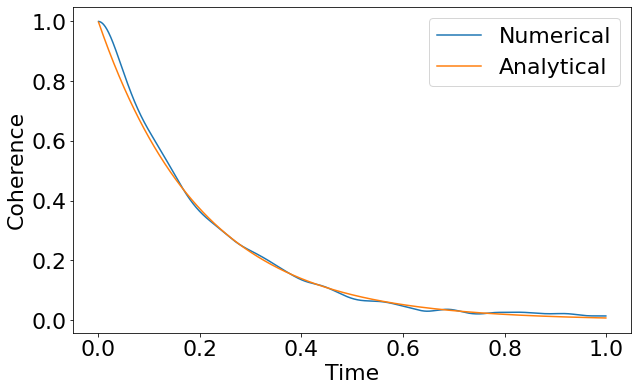

In [22]:
matplotlib.rcParams.update({'font.size': 22})

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

coherence.plot(ax=axes, label='Numerical')
long_time_coherence.plot(ax=axes, label='Analytical')

#axes.set_xlim([0,0.1])
#axes.set_ylim([0, 1])

legend = axes.legend()
axes.set_ylabel('Coherence')
axes.set_xlabel('Time')

The analytical formula relies on the fact that for a gaussian distributed variable we have

$$
\langle \exp(i \phi(t)) \rangle = \exp(- \frac{1}{2} \langle \phi(t)^2 \rangle)
$$

$$
\phi(t) = 2 \pi D \int_0^t dt^\prime \lambda(t^\prime)
$$

According to equation 3.9 on page 158 this can be calculated according to:

$$
\langle \phi(t)^2 \rangle = (2 \pi t D)^2 \int df S(f) \text{sinc}(\pi f t)^2
$$

At long times the sinc term acts as a delta function with weight $1/t$ at $f=0$. Therefore the integral reduces to $S^\text{tot}$:
$$
\langle \phi(t)^2 \rangle = 2(\pi D)^2 t S(0)
$$

Below we can see close agreement between the analyticall and numerically calculated mean square phase.

In [32]:
mean_square_phase = (phase**2).mean(axis=1)
mean_square_phase_analytical = 4*(np.pi*D)**2 * mean_square_phase.index * S0
mean_square_phase_analytical= pd.Series(mean_square_phase_analytical, index=mean_square_phase.index)

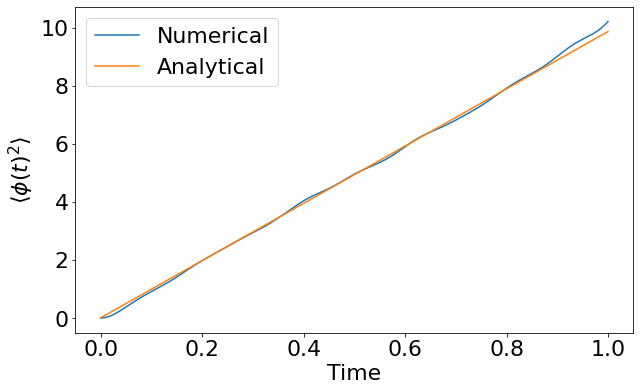

In [33]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

mean_square_phase.plot(ax=axes, label='Numerical')
mean_square_phase_analytical.plot(ax=axes, label='Analytical')

axes.set_ylabel(r'$\langle \phi(t)^2 \rangle$')
axes.set_xlabel('Time')

legend = axes.legend()